In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras


Using TensorFlow backend.


In [2]:
train=pd.read_csv('train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X=(train.iloc[:,1:].values).astype('float32')
y=(train.iloc[:,0].values).astype('int32')

In [4]:
test=pd.read_csv('test.csv')
testX=(test.iloc[:,:].values).astype('float32')

In [5]:
X.shape

(42000, 784)

In [6]:
testX.shape

(28000, 784)

In [7]:
X=X.reshape(42000,28,28)
test_X=testX.reshape(28000,28,28)


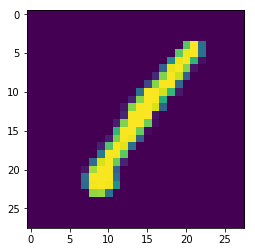

In [8]:
plt.imshow(X[0])

In [9]:
X=X.reshape(42000,28,28,1)
test_X=test_X.reshape(28000,28,28,1)
X.shape

(42000, 28, 28, 1)

In [10]:
from keras.utils import to_categorical
y=to_categorical(y)
y

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [11]:
from sklearn.model_selection import train_test_split
train_X,val_X,train_y,val_y=train_test_split(X,y,test_size=0.1,stratify=y)

In [12]:
# With data augmentation to prevent overfitting (accuracy 0.99286)
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_X)

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Activation, Dropout
from keras.layers.normalization import BatchNormalization

In [14]:
model=Sequential()

model.add(Conv2D(16,kernel_size=2,activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(32,kernel_size=2,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(64,kernel_size=2,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 27, 16)        80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
__________

In [23]:
#early stopping and reduce learning rate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
history=model.fit_generator(datagen.flow(train_X,train_y,batch_size=50),epochs=20,verbose=1,
                   steps_per_epoch=train_X.shape[0]//50,validation_data=(val_X,val_y),callbacks=callbacks)

Epoch 1/20
756/756 [==============================] - 148s 195ms/step - loss: 0.4928 - acc: 0.8446 - val_loss: 0.1447 - val_acc: 0.9548
Epoch 2/20
756/756 [==============================] - 147s 195ms/step - loss: 0.2917 - acc: 0.9078 - val_loss: 0.0948 - val_acc: 0.9724
Epoch 3/20
756/756 [==============================] - 153s 202ms/step - loss: 0.2466 - acc: 0.9214 - val_loss: 0.0958 - val_acc: 0.9736
Epoch 4/20
756/756 [==============================] - 152s 201ms/step - loss: 0.2115 - acc: 0.9325 - val_loss: 0.0865 - val_acc: 0.9731
Epoch 5/20
756/756 [==============================] - 142s 188ms/step - loss: 0.1918 - acc: 0.9385 - val_loss: 0.0785 - val_acc: 0.9776
Epoch 6/20
188/756 [======>.......................] - ETA: 1:33 - loss: 0.1825 - acc: 0.9450

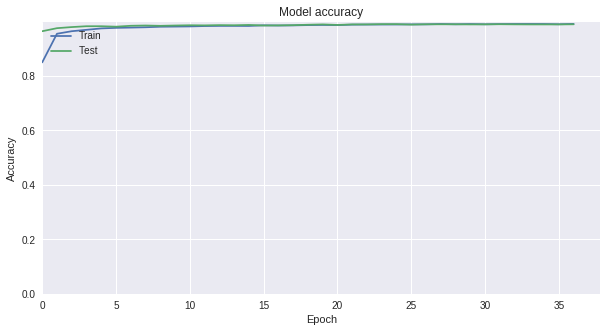

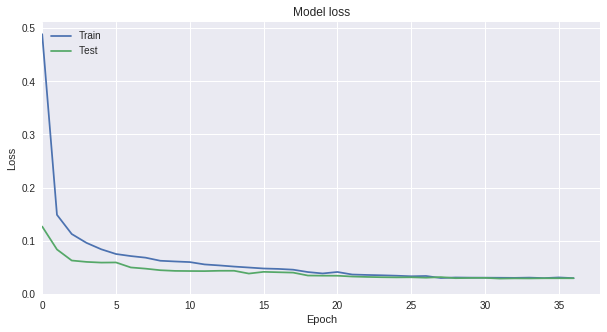

In [0]:
#multi input
#Plot training & validation accuracy values
plt.figure(figsize=(10,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.ylim(0,)
plt.xlabel('Epoch')
plt.xlim(0,)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.ylim(0,)
plt.xlabel('Epoch')
plt.xlim(0,)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
pred=model.predict(test_X,batch_size=50,verbose=1)

28000/28000 [==============================] - 3s 94us/step


In [0]:
pred1=np.argmax(pred,axis=1)
pred1

array([2, 0, 9, ..., 3, 9, 2])

In [0]:
ImageId=np.array(range(1,28001))
ImageId

array([    1,     2,     3, ..., 27998, 27999, 28000])

In [0]:
mydict={"ImageId":ImageId,"Label":pred1}
Submission=pd.DataFrame(mydict)
Submission.head(2)

,ImageId,Label
0,1,2
1,2,0


In [0]:
Submission.to_csv("submission.csv",index=False)

In [0]:
from google.colab import files
files.download('submission.csv')